<a href="https://colab.research.google.com/github/minzero-1003/capstone-project/blob/main/45%EB%A7%8C%EA%B1%B4_GPU%ED%99%9C%EC%9A%A9_HNM_%EC%A0%81%EC%9A%A9%EC%8B%9C%EC%BC%9C_%ED%95%99%EC%8A%B5%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1단계: 45만 건 데이터 확보 (API 한계 파악)
문제: 더 높은 성능을 위해 45만 건 전체 데이터로 확장을 시도했지만, API 호출 시 약 4.5만 건~5.5만 건의 데이터만 반환되었습니다. (웹사이트 개수와 불일치)

원인 진단: API가 반환하는 55만 건의 레코드 중, 우리가 필요로 하는 **eligibilityCriteria 필드('알맹이')**를 실제로 가진 데이터는 55,900건뿐이고, 나머지는 '빈 껍데기' 데이터임을 확인했습니다.

해결책: 55,900건을 우리가 사용할 수 있는 유효한 최대 데이터셋으로 확정하고 V2 파이프라인을 다시 실행했습니다.

결과: F1-Score가 0.88점으로 추가 상승했습니다. (5.5만 건 데이터 기준)

2단계: HNM 적용 (현재)
문제: 0.88점의 성능을 0.90점 이상으로 끌어올릴 필요가 있었습니다.

원인 진단: 현재 모델은 "무작위" 부정 샘플(Easy Negative)은 잘 맞추지만, "의미는 비슷하지만 정답은 아닌" **'어려운' 부정 샘플(Hard Negative)**에는 취약할 수 있습니다.

해결책: **하드 부정 샘플 마이닝(HNM)**을 적용했습니다.

GPU로 5.5만 건 Trial과 11만 건 HPO의 유사도를 모두 계산했습니다.

'유사도가 높지만' '텍스트가 포함되지 않은' **'어려운' 부정 샘플(44,721개)**을 찾아냈습니다.

긍정(21만)/하드 부정(4.4만)/무작위 부정(17.3만)을 1:1 비율로 섞어 최종 **V3 HNM 데이터셋(43만 쌍)**을 생성했습니다.

현재 상태: 방금 생성한 V3 HNM 데이터셋으로 **Siamese LSTM 모델(Step 4)**의 최종 학습을 앞두고 있습니다.

In [1]:
# HNM을 위한 유사도 계산 라이브러리 설치
!pip install sentence-transformers pandas numpy torch tqdm

from google.colab import drive
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm
import sys
import random

# Drive 마운트 및 경로 설정
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'
print(f"✅ Drive 경로: {DRIVE_PATH}")

# ⚠️ [필수]: GPU 사용 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device} (반드시 cuda여야 합니다!)")
if device == 'cpu':
    print("🔥🔥 경고: GPU 런타임으로 변경하세요! CPU로는 HNM 계산이 불가능합니다.")
    sys.exit(1)

Mounted at /content/drive
✅ Drive 경로: /content/drive/MyDrive/Colab_450k_Project/
✅ Device: cpu (반드시 cuda여야 합니다!)


In [2]:
# (normalize_text 함수 정의)
def normalize_text(text):
    if pd.isna(text): return ""
    return str(text).strip().lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

# --- 파일 로드 ---
print("⏳ 1단계: 4.5만 건 V2 임베딩 파일 로드...")
try:
    trial_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"))
    hpo_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"))

    trial_embeddings = np.load(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), allow_pickle=True)
    hpo_embeddings = np.load(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), allow_pickle=True)

    # 텍스트 리스트로 변환
    trials_criteria_normalized = trial_keys_df['original_text'].tolist()
    hpo_terms_normalized = hpo_keys_df['original_text'].tolist()

    print("✅ 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)

# --- 임베딩 텐서 변환 (GPU 계산용) ---
print("⏳ 2단계: 임베딩 텐서를 GPU로 이동...")
# HPO 용어(11만 개)가 기준이므로 GPU로 이동
# ⚠️ [수정]: CPU에서 텐서로 변환 후 GPU로 이동
hpo_embeddings_gpu = torch.tensor(hpo_embeddings, dtype=torch.float32).to(device)
# Trial 임베딩은 CPU에 유지 (메모리 절약)
trial_embeddings_cpu = torch.tensor(trial_embeddings, dtype=torch.float32)

print(f"Trial 임베딩 (CPU): {trial_embeddings_cpu.shape}")
print(f"HPO 임베딩 (GPU): {hpo_embeddings_gpu.shape}")

⏳ 1단계: 4.5만 건 V2 임베딩 파일 로드...
✅ 파일 로드 완료!
⏳ 2단계: 임베딩 텐서를 GPU로 이동...
Trial 임베딩 (CPU): torch.Size([44721, 384])
HPO 임베딩 (GPU): torch.Size([8697, 384])


In [3]:
training_data = []
seen_pairs = set()

# --- 1. 긍정 예시 (Label = 1) 생성 ---
print("\n⏳ 3단계: 긍정 데이터 생성 (속도 최적화)...")
# 긍정 샘플 생성 (이전과 동일)
for term in tqdm(hpo_terms_normalized, desc="긍정 데이터 검색 중"):
    if len(term) >= 3:
        for criteria in trials_criteria_normalized:
            if term in criteria:
                pair = (criteria, term)
                if pair not in seen_pairs:
                    training_data.append({'text_A': criteria, 'text_B': term, 'label': 1})
                    seen_pairs.add(pair)

num_positive_samples = len(training_data)
print(f"✅ 긍정 데이터 {num_positive_samples}개 생성 완료!")

# 긍정 샘플이 너무 많을 경우, HNM 계산을 위해 일부만 샘플링
# (메모리 관리: 50만 개로 제한)
if num_positive_samples > 500000:
    print(f"⚠️ 긍정 샘플이 너무 많아 50만 개로 샘플링합니다...")
    positive_samples_df = pd.DataFrame(training_data).sample(n=500000, random_state=42)
    training_data = positive_samples_df.to_dict('records')
    num_positive_samples = len(training_data)
    # seen_pairs도 업데이트 (샘플링된 데이터 기준)
    seen_pairs = set(tuple(d.values()) for d in training_data)

# --- 2. 하드 부정 예시 (Label = 0) 생성 ---
print("\n⏳ 4단계: 하드 부정 데이터 생성 (GPU 유사도 계산)...")
NUM_HARD_NEGATIVE_SAMPLES = num_positive_samples # 긍정 샘플과 1:1 매칭
K_TOP = 10 # 각 Criteria당 가장 유사한 HPO 10개 추출

hard_negative_count = 0
hard_negative_data = []

# Trial Criteria를 배치 단위로 GPU로 보내 계산 (메모리 효율적)
batch_size = 256
for i in tqdm(range(0, len(trials_criteria_normalized), batch_size), desc="HNM 검색 중"):
    # 1. 배치 생성
    batch_criteria_texts = trials_criteria_normalized[i:i+batch_size]
    batch_criteria_embeds_gpu = trial_embeddings_cpu[i:i+batch_size].to(device)

    # 2. 코사인 유사도 계산 (GPU)
    # (batch_size, 11만 개 HPO) 유사도 매트릭스 생성
    cos_scores = util.cos_sim(batch_criteria_embeds_gpu, hpo_embeddings_gpu)

    # 3. Top-K 추출 (가장 유사한 HPO)
    # scores: 유사도 점수, indices: HPO 인덱스
    top_k_scores, top_k_indices = torch.topk(cos_scores, k=K_TOP, dim=1)

    # 4. CPU로 결과 이동 및 Hard Negative 선별
    top_k_indices_cpu = top_k_indices.cpu().numpy()

    for criteria_idx_in_batch, hpo_indices in enumerate(top_k_indices_cpu):
        criteria_text = batch_criteria_texts[criteria_idx_in_batch]

        for hpo_idx in hpo_indices:
            hpo_term_text = hpo_terms_normalized[hpo_idx]

            # 5. [핵심] 텍스트에 포함되지 *않았지만* 유사도가 높은 샘플 선별
            if len(hpo_term_text) >= 3 and (hpo_term_text not in criteria_text):
                pair = (criteria_text, hpo_term_text)
                if pair not in seen_pairs:
                    hard_negative_data.append({'text_A': criteria_text, 'text_B': hpo_term_text, 'label': 0})
                    seen_pairs.add(pair)
                    hard_negative_count += 1
                    break # 각 Criteria당 1개의 Hard Negative만 추가

    # GPU 캐시 비우기
    del batch_criteria_embeds_gpu, cos_scores, top_k_scores, top_k_indices
    torch.cuda.empty_cache()

# Hard Negative가 목표보다 많으면 샘플링, 적으면 그대로 사용
if hard_negative_count > NUM_HARD_NEGATIVE_SAMPLES:
    print(f" - 하드 부정 샘플이 많아 {NUM_HARD_NEGATIVE_SAMPLES}개로 샘플링합니다.")
    random.shuffle(hard_negative_data)
    hard_negative_data = hard_negative_data[:NUM_HARD_NEGATIVE_SAMPLES]

training_data.extend(hard_negative_data)
print(f"✅ 하드 부정 데이터 {len(hard_negative_data)}개 생성 완료!")


# --- 3. (선택적) 무작위 부정 예시 (Label 0) 생성 ---
# 만약 Hard Negative가 목표치(num_positive_samples)에 도달하지 못했다면,
# 부족한 만큼 무작위(Easy) 부정 샘플로 채웁니다.
num_easy_negatives = num_positive_samples - len(hard_negative_data)

if num_easy_negatives > 0:
    print(f"\n⏳ 5단계: 부족한 {num_easy_negatives}개의 무작위(Easy) 부정 데이터 생성...")
    easy_negative_count = 0
    with tqdm(total=num_easy_negatives, desc="Easy 부정 데이터 생성 중") as pbar:
        while easy_negative_count < num_easy_negatives:
            random_criteria = random.choice(trials_criteria_normalized)
            random_term = random.choice(hpo_terms_normalized)

            if len(random_term) >= 3 and random_term in random_criteria:
                continue

            pair = (random_criteria, random_term)
            if pair not in seen_pairs:
                training_data.append({'text_A': random_criteria, 'text_B': random_term, 'label': 0})
                seen_pairs.add(pair)
                easy_negative_count += 1
                pbar.update(1)
    print(f"✅ 무작위 부정 데이터 {easy_negative_count}개 생성 완료!")

# --- 최종 CSV 파일로 저장 ---
print("\n⏳ 6단계: 'training_data_450k_v3_HNM.csv' 파일로 저장합니다...")
final_df = pd.DataFrame(training_data)
final_df = final_df.sample(frac=1).reset_index(drop=True) # 데이터 섞기
final_df.to_csv(os.path.join(DRIVE_PATH, "training_data_450k_v3_HNM.csv"), index=False, encoding='utf-8-sig')

print("\n🎉🎉🎉 성공! 'training_data_450k_v3_HNM.csv' 파일이 Drive에 생성되었습니다! 🎉🎉🎉")
print(f"총 {len(final_df)}개의 균형 잡힌 학습 데이터가 만들어졌습니다.")


⏳ 3단계: 긍정 데이터 생성 (속도 최적화)...


긍정 데이터 검색 중: 100%|██████████| 8697/8697 [07:54<00:00, 18.34it/s]


✅ 긍정 데이터 218385개 생성 완료!

⏳ 4단계: 하드 부정 데이터 생성 (GPU 유사도 계산)...


HNM 검색 중: 100%|██████████| 175/175 [00:07<00:00, 23.08it/s]


✅ 하드 부정 데이터 44721개 생성 완료!

⏳ 5단계: 부족한 173664개의 무작위(Easy) 부정 데이터 생성...


Easy 부정 데이터 생성 중: 100%|██████████| 173664/173664 [00:00<00:00, 253941.91it/s]


✅ 무작위 부정 데이터 173664개 생성 완료!

⏳ 6단계: 'training_data_450k_v3_HNM.csv' 파일로 저장합니다...

🎉🎉🎉 성공! 'training_data_450k_v3_HNM.csv' 파일이 Drive에 생성되었습니다! 🎉🎉🎉
총 436770개의 균형 잡힌 학습 데이터가 만들어졌습니다.


샴 LSTM

✅ Device: cpu (반드시 'cuda'여야 합니다!)
⏳ 1단계: HNM 학습 데이터(V3) 및 임베딩 파일 로드...
✅ HNM (V3) 파일 로드 완료!
⏳ 2단계: Siamese 구조를 위한 벡터 쌍 분리 생성...


데이터 쌍 벡터화 중: 100%|██████████| 436770/436770 [00:38<00:00, 11433.95it/s]



✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.
✅ 학습 데이터: 349416개, 테스트 데이터: 87354개

✅ Siamese LSTM 모델 정의 완료! (HNM V3 데이터로 학습)


Epoch 1/10 [학습]: 100%|██████████| 5459/5459 [00:49<00:00, 110.29it/s]


Epoch [1/10] | Loss: 0.6535 | Val F1: 0.8369


Epoch 2/10 [학습]: 100%|██████████| 5459/5459 [00:49<00:00, 109.80it/s]


Epoch [2/10] | Loss: 0.4281 | Val F1: 0.8565


Epoch 3/10 [학습]: 100%|██████████| 5459/5459 [00:49<00:00, 109.48it/s]


Epoch [3/10] | Loss: 0.3331 | Val F1: 0.8683


Epoch 4/10 [학습]: 100%|██████████| 5459/5459 [00:48<00:00, 113.58it/s]


Epoch [4/10] | Loss: 0.3098 | Val F1: 0.8757


Epoch 5/10 [학습]: 100%|██████████| 5459/5459 [00:49<00:00, 111.06it/s]


Epoch [5/10] | Loss: 0.2961 | Val F1: 0.8802


Epoch 6/10 [학습]: 100%|██████████| 5459/5459 [00:48<00:00, 111.51it/s]


Epoch [6/10] | Loss: 0.2870 | Val F1: 0.8839


Epoch 7/10 [학습]: 100%|██████████| 5459/5459 [00:54<00:00, 99.29it/s]


Epoch [7/10] | Loss: 0.2796 | Val F1: 0.8871


Epoch 8/10 [학습]: 100%|██████████| 5459/5459 [00:49<00:00, 111.02it/s]


Epoch [8/10] | Loss: 0.2729 | Val F1: 0.8897


Epoch 9/10 [학습]: 100%|██████████| 5459/5459 [00:48<00:00, 111.93it/s]


Epoch [9/10] | Loss: 0.2680 | Val F1: 0.8920


Epoch 10/10 [학습]: 100%|██████████| 5459/5459 [00:48<00:00, 112.58it/s]


Epoch [10/10] | Loss: 0.2634 | Val F1: 0.8938

=== 최종 Classification Report (Siamese LSTM - HNM V3 Data) ===
              precision    recall  f1-score   support

         0.0     0.9277    0.8438    0.8838     43652
         1.0     0.8567    0.9342    0.8938     43644

    accuracy                         0.8890     87296
   macro avg     0.8922    0.8890    0.8888     87296
weighted avg     0.8922    0.8890    0.8888     87296


⏳ 학습 과정 시각화 중...


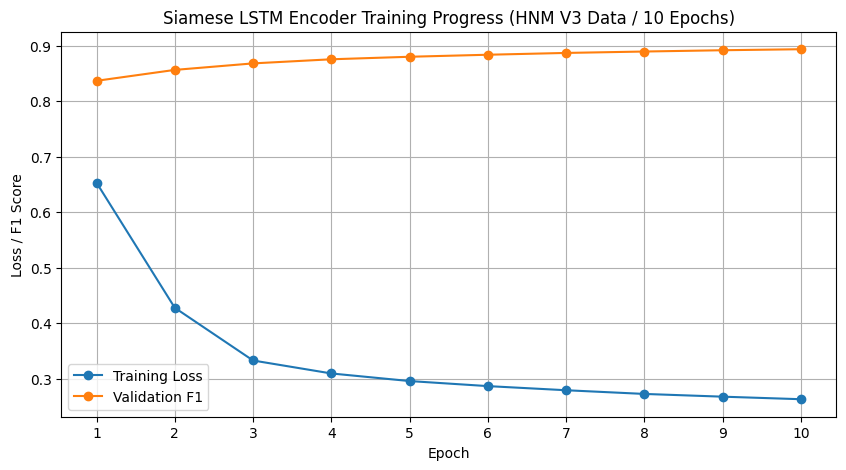

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device} (반드시 'cuda'여야 합니다!)")

# Drive 경로
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'

# --- 1. 파일 로드 ---
print("⏳ 1단계: HNM 학습 데이터(V3) 및 임베딩 파일 로드...")
try:
    # ⚠️ [수정]: V3 HNM 파일 로드
    training_df = pd.read_csv(os.path.join(DRIVE_PATH, "training_data_450k_v3_HNM.csv"))

    trial_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"))
    hpo_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"))

    trial_embeddings = np.load(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), allow_pickle=True)
    hpo_embeddings = np.load(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), allow_pickle=True)
    print("✅ HNM (V3) 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)

# 임베딩 딕셔너리 생성
trial_embed_map = dict(zip(trial_keys_df['original_text'], trial_embeddings))
hpo_embed_map = dict(zip(hpo_keys_df['original_text'], hpo_embeddings))

# --- 2. 벡터 쌍 생성 (Siamese 구조) ---
print("⏳ 2단계: Siamese 구조를 위한 벡터 쌍 분리 생성...")
X_A = [] # Criteria 벡터
X_B = [] # HPO Term 벡터
labels = []
mismatch_count = 0

for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 벡터화 중"):
    text_A = str(row['text_A'])
    text_B = str(row['text_B'])
    label = row['label']

    vector_A = trial_embed_map.get(text_A)
    vector_B = hpo_embed_map.get(text_B)

    if vector_A is not None and vector_B is not None:
        X_A.append(vector_A.astype(np.float32))
        X_B.append(vector_B.astype(np.float32))
        labels.append(label)
    else:
        mismatch_count += 1

if mismatch_count > 0:
    print(f"\n🔥🔥 경고: {mismatch_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다.")
else:
    print("\n✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.")

X_A = np.array(X_A)
X_B = np.array(X_B)
y = np.array(labels)
embedding_dim = X_A.shape[1]

# --- 3. 데이터셋 분할 ---
X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = train_test_split(
    X_A, X_B, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ 학습 데이터: {len(X_A_train)}개, 테스트 데이터: {len(X_A_test)}개")


# ======================================#
# 4️⃣ Siamese LSTM 모델 정의
# ======================================
# (Dataset, LSTMEncoder, SiameseNetwork 클래스 정의는 이전과 동일)
class SiameseEmbeddingDataset(Dataset):
    def __init__(self, X_A, X_B, y):
        self.X_A = torch.tensor(X_A, dtype=torch.float32)
        self.X_B = torch.tensor(X_B, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X_A)
    def __getitem__(self, idx): return self.X_A[idx], self.X_B[idx], self.y[idx]

train_ds = SiameseEmbeddingDataset(X_A_train, X_B_train, y_train)
test_ds = SiameseEmbeddingDataset(X_A_test, X_B_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=64, drop_last=True)

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, output_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        out = self.dropout(h.squeeze(0))
        return out

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(SiameseNetwork, self).__init__()
        self.shared_encoder = LSTMEncoder(input_dim, output_dim=hidden_dim)
        self.fc_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 1)
        )
    def forward(self, x1, x2):
        encoded_x1 = self.shared_encoder(x1)
        encoded_x2 = self.shared_encoder(x2)
        diff = torch.abs(encoded_x1 - encoded_x2)
        out = self.fc_classifier(diff)
        return torch.sigmoid(out).squeeze(-1)

# 모델, 손실 함수, 옵티마이저 정의
model = SiameseNetwork(input_dim=embedding_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print("\n✅ Siamese LSTM 모델 정의 완료! (HNM V3 데이터로 학습)")

# --- 5. 학습 루프 및 평가 ---
EPOCHS = 10
train_loss_list, val_f1_list = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb_A, Xb_B, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
        Xb_A, Xb_B, yb = Xb_A.to(device), Xb_B.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb_A, Xb_B)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # --- 검증 단계 ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xb_A, Xb_B, yb in test_loader:
            Xb_A, Xb_B = Xb_A.to(device), Xb_B.to(device)
            probs = model(Xb_A, Xb_B).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            if preds.ndim == 0:
                all_preds.append(int(preds))
            else:
                all_preds.extend(preds.tolist())
            all_labels.extend(yb.numpy().tolist())

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    val_f1_list.append(f1)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f}")

# --- 6. 최종 평가 ---
print("\n=== 최종 Classification Report (Siamese LSTM - HNM V3 Data) ===")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

# --- 7. 시각화 ---
print("\n⏳ 학습 과정 시각화 중...")
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
plt.title(f"Siamese LSTM Encoder Training Progress (HNM V3 Data / {EPOCHS} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss / F1 Score")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.grid(True)
plt.show()

샴 MLP

✅ Device: cpu (반드시 'cuda'여야 합니다!)
✅ 모델 저장 경로: /content/drive/MyDrive/Colab_450k_Project/MLP_Checkpoints/
✅ 450k HNM (V3) 파일 로드 완료!
Training Data shape: (436770, 3)
✅ 새로운 임베딩 차원: 384

⏳ HNM V3 데이터를 기반으로 벡터 쌍을 생성합니다...


데이터 쌍 생성 중: 100%|██████████| 436770/436770 [00:17<00:00, 24431.90it/s]


✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.
✅ 학습 데이터: 349416개, 테스트 데이터: 87354개

✅ Siamese MLP 모델 정의 완료! (HNM V3 데이터로 학습)

⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...


Epoch 1/10 [학습]: 100%|██████████| 5459/5459 [00:32<00:00, 169.78it/s]


  ✨ **CheckPoint 저장됨**: Epoch 1, F1: 0.8762 (Google Drive)
Epoch [1/10] | Loss: 0.4854 | Val F1: 0.8762 (Best F1: 0.8762)


Epoch 2/10 [학습]: 100%|██████████| 5459/5459 [00:31<00:00, 170.89it/s]


  ✨ **CheckPoint 저장됨**: Epoch 2, F1: 0.8946 (Google Drive)
Epoch [2/10] | Loss: 0.2929 | Val F1: 0.8946 (Best F1: 0.8946)


Epoch 3/10 [학습]: 100%|██████████| 5459/5459 [00:31<00:00, 170.71it/s]


  ✨ **CheckPoint 저장됨**: Epoch 3, F1: 0.9043 (Google Drive)
Epoch [3/10] | Loss: 0.2659 | Val F1: 0.9043 (Best F1: 0.9043)


Epoch 4/10 [학습]: 100%|██████████| 5459/5459 [00:38<00:00, 141.35it/s]


  ✨ **CheckPoint 저장됨**: Epoch 4, F1: 0.9109 (Google Drive)
Epoch [4/10] | Loss: 0.2500 | Val F1: 0.9109 (Best F1: 0.9109)


Epoch 5/10 [학습]: 100%|██████████| 5459/5459 [00:32<00:00, 168.87it/s]


  ✨ **CheckPoint 저장됨**: Epoch 5, F1: 0.9156 (Google Drive)
Epoch [5/10] | Loss: 0.2388 | Val F1: 0.9156 (Best F1: 0.9156)


Epoch 6/10 [학습]: 100%|██████████| 5459/5459 [00:32<00:00, 167.11it/s]


  ✨ **CheckPoint 저장됨**: Epoch 6, F1: 0.9202 (Google Drive)
Epoch [6/10] | Loss: 0.2289 | Val F1: 0.9202 (Best F1: 0.9202)


Epoch 7/10 [학습]: 100%|██████████| 5459/5459 [00:31<00:00, 171.96it/s]


  ✨ **CheckPoint 저장됨**: Epoch 7, F1: 0.9234 (Google Drive)
Epoch [7/10] | Loss: 0.2217 | Val F1: 0.9234 (Best F1: 0.9234)


Epoch 8/10 [학습]: 100%|██████████| 5459/5459 [00:31<00:00, 171.95it/s]


  ✨ **CheckPoint 저장됨**: Epoch 8, F1: 0.9257 (Google Drive)
Epoch [8/10] | Loss: 0.2144 | Val F1: 0.9257 (Best F1: 0.9257)


Epoch 9/10 [학습]: 100%|██████████| 5459/5459 [00:32<00:00, 169.03it/s]


  ✨ **CheckPoint 저장됨**: Epoch 9, F1: 0.9279 (Google Drive)
Epoch [9/10] | Loss: 0.2083 | Val F1: 0.9279 (Best F1: 0.9279)


Epoch 10/10 [학습]: 100%|██████████| 5459/5459 [00:32<00:00, 168.15it/s]


  ✨ **CheckPoint 저장됨**: Epoch 10, F1: 0.9297 (Google Drive)
Epoch [10/10] | Loss: 0.2036 | Val F1: 0.9297 (Best F1: 0.9297)

=== 최종 Classification Report (Siamese MLP Encoder - HNM V3 Data) ===
              precision    recall  f1-score   support

         0.0     0.9375    0.9194    0.9284     43652
         1.0     0.9209    0.9387    0.9297     43644

    accuracy                         0.9291     87296
   macro avg     0.9292    0.9291    0.9291     87296
weighted avg     0.9292    0.9291    0.9291     87296



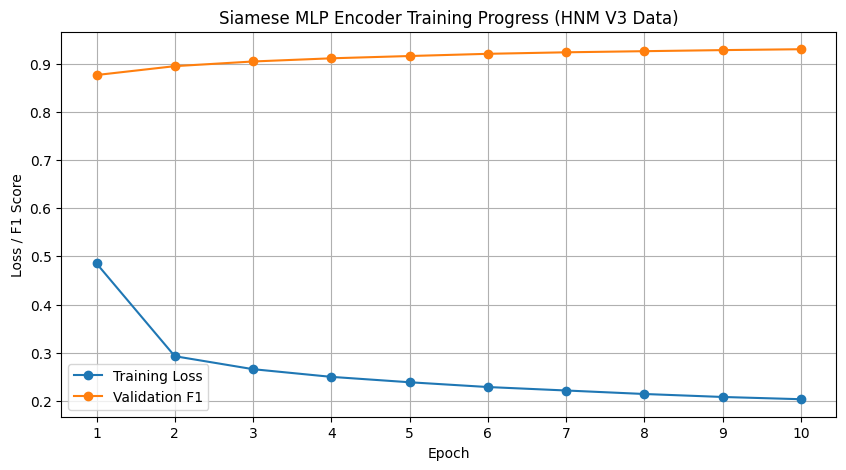

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device} (반드시 'cuda'여야 합니다!)")

# ⚠️ [경로 수정]: 스크린샷에 명시된 V2가 아닌 원본 경로
DRIVE_PATH = '/content/drive/MyDrive/Colab_450k_Project/'
MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'MLP_Checkpoints/')
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✅ 모델 저장 경로: {MODEL_SAVE_PATH}")


# ======================================#
# 1️⃣ CSV 불러오기 (HNM V3 데이터로 수정)
# ======================================
try:
    # ⚠️ [수정]: HNM V3 파일 로드
    training_df = pd.read_csv(os.path.join(DRIVE_PATH, "training_data_450k_v3_HNM.csv"))

    trial_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "trial_keys_450k.csv"))
    hpo_keys_df = pd.read_csv(os.path.join(DRIVE_PATH, "hpo_keys_full.csv"))

    trial_vecs = np.load(os.path.join(DRIVE_PATH, "trial_embeddings_450k_FINAL.npy"), allow_pickle=True)
    hpo_vecs = np.load(os.path.join(DRIVE_PATH, "hpo_embeddings_full.npy"), allow_pickle=True)

    print("✅ 450k HNM (V3) 파일 로드 완료!")
except FileNotFoundError as e:
    print(f"🔥🔥 오류: 필요한 파일이 없습니다. '{e.filename}'이 Drive에 있는지 확인하세요.")
    sys.exit(1)


# --- 1.2 임베딩 데이터 준비 ---
print(f"Training Data shape: {training_df.shape}")
trial_text_to_idx = {str(text): idx for idx, text in enumerate(trial_keys_df['original_text'])}
hpo_text_to_idx = {str(text): idx for idx, text in enumerate(hpo_keys_df['original_text'])}
embedding_dim = trial_vecs.shape[1]
print(f"✅ 새로운 임베딩 차원: {embedding_dim}")

# ======================================#
# 2️⃣ 입력 시퀀스 생성 (Siamese 구조)
# ======================================
# (이전 코드와 동일 - V3 데이터를 기반으로 벡터 쌍 생성)
print("\n⏳ HNM V3 데이터를 기반으로 벡터 쌍을 생성합니다...")
X_A = [] # Criteria 벡터
X_B = [] # HPO Term 벡터
labels = []
mismatch_count = 0

for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="데이터 쌍 생성 중"):
    text_a = str(row['text_A'])
    text_b = str(row['text_B'])
    label = row['label']

    idx_a = trial_text_to_idx.get(text_a)
    idx_b = hpo_text_to_idx.get(text_b)

    if idx_a is not None and idx_b is not None:
        X_A.append(trial_vecs[idx_a])
        X_B.append(hpo_vecs[idx_b])
        labels.append(label)
    else:
        mismatch_count += 1

if mismatch_count > 0:
    print(f"⚠️ 경고: {mismatch_count}개의 텍스트 쌍에 대한 벡터를 찾지 못했습니다.")
else:
    print("✅ 모든 데이터 쌍에 대한 벡터를 성공적으로 찾았습니다.")

X_A = np.array(X_A)
X_B = np.array(X_B)
y = np.array(labels)

if len(X_A) > 0:
    # ======================================#
    # 3️⃣ Dataset 정의 (Siamese 구조)
    # ======================================
    class SiameseEmbeddingDataset(Dataset):
        def __init__(self, X_A, X_B, y):
            self.X_A = torch.tensor(X_A, dtype=torch.float32)
            self.X_B = torch.tensor(X_B, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self): return len(self.X_A)
        def __getitem__(self, idx):
            return self.X_A[idx], self.X_B[idx], self.y[idx]

    if len(np.unique(y)) < 2 or np.min(np.bincount(y)) < 2:
         print("🔥🔥 오류: 학습/테스트 데이터 분리 후 각 클래스에 샘플이 부족합니다. 데이터셋 크기를 확인하세요.")
         X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = [np.array([])]*6
    else:
        X_A_train, X_A_test, X_B_train, X_B_test, y_train, y_test = train_test_split(
            X_A, X_B, y, test_size=0.2, random_state=42, stratify=y
        )

    if len(X_A_train) > 0 and len(X_A_test) > 0:
        train_ds = SiameseEmbeddingDataset(X_A_train, X_B_train, y_train)
        test_ds = SiameseEmbeddingDataset(X_A_test, X_B_test, y_test)

        # ⚠️ [수정]: 런타임 오류 방지를 위해 drop_last=True 추가
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=64, drop_last=True)
        print(f"✅ 학습 데이터: {len(X_A_train)}개, 테스트 데이터: {len(X_A_test)}개")

        # ======================================#
        # 4️⃣ Siamese MLP 모델 정의
        # ======================================

        class MLPEncoder(nn.Module):
            def __init__(self, input_dim, output_dim=128):
                super(MLPEncoder, self).__init__()
                self.fc1 = nn.Linear(input_dim, input_dim // 2)
                self.relu1 = nn.ReLU()
                self.dropout = nn.Dropout(0.3)
                self.fc2 = nn.Linear(input_dim // 2, output_dim)

            def forward(self, x):
                x = self.fc1(x)
                x = self.relu1(x)
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        class SiameseMLPNetwork(nn.Module):
            def __init__(self, input_dim, hidden_dim=128):
                super(SiameseMLPNetwork, self).__init__()
                self.shared_encoder = MLPEncoder(input_dim, output_dim=hidden_dim)
                self.fc_classifier = nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim // 2),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(hidden_dim // 2, 1)
                )

            def forward(self, x1, x2):
                encoded_x1 = self.shared_encoder(x1)
                encoded_x2 = self.shared_encoder(x2)
                diff = torch.abs(encoded_x1 - encoded_x2)
                out = self.fc_classifier(diff)
                return torch.sigmoid(out).squeeze(-1)

        model = SiameseMLPNetwork(input_dim=embedding_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        print("\n✅ Siamese MLP 모델 정의 완료! (HNM V3 데이터로 학습)")

        best_f1 = 0.0

        # ======================================#
        # 5️⃣ 학습 루프 (Siamese 구조)
        # ======================================
        EPOCHS = 10
        train_loss_list, val_f1_list = [], []

        print("\n⏳ 모델 학습을 시작합니다 (Google Drive에 체크포인트 저장)...")
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            for Xb_A, Xb_B, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [학습]"):
                Xb_A, Xb_B, yb = Xb_A.to(device), Xb_B.to(device), yb.to(device)

                optimizer.zero_grad()
                outputs = model(Xb_A, Xb_B)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            train_loss_list.append(avg_loss)

            # --- 검증 단계 ---
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xb_A, Xb_B, yb in test_loader:
                    Xb_A, Xb_B = Xb_A.to(device), Xb_B.to(device)
                    probs = model(Xb_A, Xb_B).cpu().numpy()
                    preds = (probs > 0.5).astype(int)

                    if preds.ndim == 0:
                        all_preds.append(int(preds))
                    else:
                        all_preds.extend(preds.tolist())

                    all_labels.extend(yb.numpy().tolist())

            f1 = f1_score(all_labels, all_preds, zero_division=0)
            val_f1_list.append(f1)

            # --- ✨ 체크포인트 저장 로직 ✨ ---
            if f1 > best_f1:
                best_f1 = f1
                # ⚠️ [수정]: 체크포인트 파일명 변경
                model_path = os.path.join(MODEL_SAVE_PATH, f"Siamese_MLP_HNM_best_epoch_{epoch+1}_f1_{f1:.4f}.pth")
                torch.save(model.state_dict(), model_path)
                print(f"  ✨ **CheckPoint 저장됨**: Epoch {epoch+1}, F1: {f1:.4f} (Google Drive)")

            print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Val F1: {f1:.4f} (Best F1: {best_f1:.4f})")

        # ======================================#
        # 6️⃣ 최종 평가 및 시각화
        # ======================================
        print("\n=== 최종 Classification Report (Siamese MLP Encoder - HNM V3 Data) ===")
        print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, EPOCHS + 1), train_loss_list, label="Training Loss", marker='o')
        plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1", marker='o')
        # ⚠️ [수정]: 그래프 제목 변경
        plt.title("Siamese MLP Encoder Training Progress (HNM V3 Data)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss / F1 Score")
        plt.xticks(range(1, EPOCHS + 1))
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("🔥🔥 오류: 학습 또는 테스트 데이터셋 크기가 0입니다. 데이터 분리 설정을 확인하세요.")
else:
    print("🔥🔥 오류: 유효한 데이터 쌍이 없어 모델 학습을 진행할 수 없습니다.")